In [1]:
from IPython.display import Image

# 17.3 합성곱 GAN과 바서슈타인 GAN으로 합성 이미지 품질 높이기
* 전치 합성곱
* 배치 정규화
* WGAN
* 그레이디언트 페널티

DCGAN은 생성자와 판별자 신경망에 합성곱을 사용한다. 먼저 DCGAN은 랜덤 벡터 z를 완전 연결 층으로 적당한 크기의 새로운 벡터로 투영한다. 그다음 합성곱에 사용되는 형태로 크기를 바꾼다(h * w * c). 이 크기의 출력 이미지 크기보다 작다. 그 다음 몇개의 전치 합성곱(transposed convolution) 층을 사용하여 이 특성 맵을 원하는 출력 크기까지 업샘플링 한다.

### 17.3.1 전치 합성곱
* 합성곱 연산: 특성 맵을 다운샘플링
* 전치 합성곱 연산: 특성 맵을 업샘플링

In [2]:
# 합성곱과 전치 합성곱
Image(url='https://git.io/JLjn7', width=700)

* 전치 합성곱과 역합성곱

전치 합성곱은 분할 스트라이드 합성곱(fractionally strided convolution)이라고도 부른다. 딥러닝 논문에서 전치 합성곱을 의미할 때는 사용하는 또 다른 용어는 역합성곱(deconvolution)이다. 하지만 역합성곱은 합성곱 연산의 역으로 정의되어 있다. 특성 맵 x, 가중치 파라미터 w에서 특성 맵 $x'$를 만드는 합성곱 연산 f를 $f_w(x)=x'$와 같이 쓸 수 있다. 역합성곱 $f^{-1}$은 $f^{-1}_w(f(x))=x$와 같이 쓸 수 있다. 하지만 전치 합성곱은 단지 특성 공간의 차원을 복원하는 데만 초점을 맞추며 실제 값은 복원하지 않는다.

전치 합성곱은 입력 특성 맵의 원소 사이에 0을 끼워넣어 합성곱을 수행하는 식으로 특성 맵을 업샘플링한다.

In [3]:
# 2 * 2 스트라이드와 2 * 2 커널을 사용한 전치 합성곱
Image(url='https://git.io/JLjnb', width=700)

입력 특성 맵에 0을 끼워넣은 것이 가운데 9 * 9 크기의 행렬이다. 그 다음 2 * 2 크기의 커널과 스트라이드 1로 보통의 합성곱을 수행하여 8 * 8 크기 출력을 만든다. 이 합성곱을 반대 방향으로 검증 해보기 위해 9 * 9 크기의 행렬에 스트라이드 2로 보통 합성곱을 적용하면 원본 입력 크기와 같은 4 * 4 크기의 특성 맵이 출력된다.

### 17.3.2 배치 정규화(Batch Normalization, BatchNorm, BN)
* 층의 입력을 정규화하고 훈련하는 동안 입력 분포의 변화는 막는 것
    * 모델을 빠르고 안정적으로 수렴하게 만든다.
* 배치 정규화는 계산된 통계 값을 기반으로 미니 배치의 특성을 변환한다.

합성곱 층과 활성화 함수 사이에 있는 특성맵이 [m * h * w * c] 크기의 4차원 텐서 Z라고 가정한다. 
* m: 배치에 있는 샘플의 개수(배치 크기)
* h * w: 특성 맵의 공간 방향 차원
* c: 채널 개수

배치 정규화 단계
1. 미니 배치 입력의 평균 $\mu_B$과 표준 편차 $\sigma_B$ 계산

$$\mu_B = \frac{1}{m * h * w}\sum_{i,j,k}Z^{[i,j,k,.]}$$
$$\sigma^2_B = \frac{1}{m * h * w}\sum_{i,j,k}(Z^{[i,j,k,.]}-\mu_B)^2$$

여기서 $\mu_B$와 $\sigma^2_B$의 크기는 c이다.

2. 배치에 있는 모든 샘플의 입력을 표준화한다. 미니 배치의 샘플을 z 점수 정규화(표준화)로 변환하여 표준화된 $Z^{[i]}_{std}=\frac{Z^{[i]}-\mu_B}{\sigma_B + \epsilon}$ (여기서 $ϵ$은 수치 안정성(즉, 0 나눗셈 방지)을 위한 작은 값)을 만든다. 결국 입력 값은 원점에 맞춰지고 단위 분산을 가지게 된다. 이는 경사 하강법 기반의 최적화 방식에 바람직한 성질이다. 반면 각기 다른 미니 배치에서 동일한 성질을 갖도록 항상 입력을 정규화하면 신경망의 표현 능을에 큰 영향을 미칠 수 있다. x~N(0, 1)인 특성이 시그모이드 함수 $\sigma(x)$를 통과할 때 0에 가까운 값은 선형적인 영역을 만들기 때문이다.
3. 정규화된 입력을 학습되는 두개의 파라미터 $\gamma$와 $\beta$로 스케일을 조정하고 이동시킨다. 이 파라미터의 크기는 c(채널 개수)이다. $A^{[i]}_{pre} = \gamma Z^{[i]}_{std} + \beta$

훈련하는 동안 이동 평균 $\mu_B$와 이동 분산 $\sigma^2_B$을 계산한다. 이 값과 튜닝 파라미터 $\beta$와 $\gamma$를 함께 사용하여 평가 시에 테스트 샘플을 정규화한다.

* 텐서플로 케라스 API의 배치 클래스 `tf.kears.layers.BatchNormalization()`
    * 배치 정규화의 모든 단계를 수행
    * 학습되는 파라미터 $\gamma$와 $\beta$는 `training=False` 또는 `training=True`를 설정하여 업데이트되는 동작을 결정할 수 있다.
        * 케라스는 이 매개변수를 사용하여 훈련하는 동안만 이 파라미터를 업데이트한다.

In [4]:
# 배치 정규화
Image(url='https://git.io/JLjnA', width=700)

### 17.3.3 생성자와 판별자 구현

* 생성자
    * 크기가 20인 벡터 z를 입력으로 받아 완전 연결 (밀집) 층을 적용하여 크기를 6,272로 늘린다.
    * 크기가 7 * 7 * 128인 랭크 3 텐서로 변환한다(공간 방향 차원이 7 * 7, 채널 개수 128)
    * `tf.keras.layers.Conv2DTranspose()`를 사용한 전치 합성곱 몇 개를 거쳐 이 특성 맵을 공간 방향의 차원이 28 * 28이 될 때까지 업샘플링한다. 전치 합성곱 층을 지나면서 채널 개수는 절반으로 줄어든다. 예외적으로 마지막 전치 합성곱은 흑백 이미지를 만들기 위해 하나의 출력 필더만 사용한다.
    * 배치 정규화와 `LeakyReLU` 활성화 함수
    * 마지막 전치 합성곱 층에는 (배치 정규화 없이) tanh 활성화 함수 사용

In [5]:
# 생성자 신경망 구조
Image(url='https://git.io/JLjnx', width=700)

* 판별자
    * 28 * 28 * 1 크기의 이미지를 입력으로 받아 네 개의 합성곱을 통과시킨다.
    * 처음 세 개의 합성곱 층은 공간 차원을 4배로 줄이고 특성 맵의 차원 개수를 늘린다
    * 각 합성곱 층 다음에는 배치 정규화와 `LeakyReLU` 활성화 함수, rate=0.3(드롭아웃 확률)인 드롭아웃 층이 뒤따른다.
    * 마지막 합성곱 층은 7 * 7 크기의 커널을 사용하고 하나의 필터를 사용하여 출력 차원을 1 * 1 * 1로 줄인다.

In [6]:
# 판별자 신경망 구조
Image(url='https://git.io/JLjnj', width=700)

In [7]:
import tensorflow as tf


print(tf.__version__)

print("GPU 여부:", len(tf.config.list_physical_devices('GPU')) > 0)

if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'CPU:0'
    
print(device_name)

2.6.2
GPU 여부: True


2022-02-25 05:29:36.322110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 05:29:36.422711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 05:29:36.423445: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


/device:GPU:0


2022-02-25 05:29:36.428215: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-25 05:29:36.429009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 05:29:36.429698: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 05:29:36.430339: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [8]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [9]:
def make_dcgan_generator(
        z_size=20, 
        output_size=(28, 28, 1),
        n_filters=128, 
        n_blocks=2):
    size_factor = 2**n_blocks # 2 ** 2 = 4
    hidden_size = (
        output_size[0]//size_factor, # 28 // 4 = 7
        output_size[1]//size_factor) # 28 // 4 = 7
    
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(z_size,)),
        tf.keras.layers.Dense(
            units=n_filters*np.prod(hidden_size), # 128 * 7 * 7
            use_bias=False), # 배치 정규화 앞의층에서는 절편 유닛을 사용하지 않는 것을 권장. 배치 정규화가 이미 이동 파라미터 절편을 가지고 있기 때문
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape(
            (hidden_size[0], hidden_size[1], n_filters)), # 7 * 7 * 128 크기
        tf.keras.layers.Conv2DTranspose(
            filters=n_filters, kernel_size=(5, 5), strides=(1, 1),
            padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])

    nf = n_filters 
    for i in range(n_blocks):
        nf = nf // 2 # 0 -> 64, 1 -> 32 => 28 * 28 * 32
        model.add(
            tf.keras.layers.Conv2DTranspose(
                filters=nf, kernel_size=(5, 5), strides=(2, 2),
                padding='same', use_bias=False))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
    model.add(
        tf.keras.layers.Conv2DTranspose(
            filters=output_size[2], kernel_size=(5, 5), 
            strides=(1, 1), padding='same', use_bias=False, 
            activation='tanh'))
    return model

In [10]:
def make_dcgan_discriminator(
        input_size=(28, 28, 1),
        n_filters=64, 
        n_blocks=2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_size),
        tf.keras.layers.Conv2D(
            filters=n_filters, kernel_size=5, 
            strides=(1, 1), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU()
    ])

    nf = n_filters
    for i in range(n_blocks):
        nf = nf*2
        model.add(
            tf.keras.layers.Conv2D(
                filters=nf, kernel_size=(5, 5), 
                strides=(2, 2),padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.3))
        
    model.add(tf.keras.layers.Conv2D(
            filters=1, kernel_size=(7, 7), padding='valid'))
    model.add(tf.keras.layers.Reshape((1,)))
    return model

In [11]:
gen_model = make_dcgan_generator()
gen_model.summary()

disc_model = make_dcgan_discriminator()
disc_model.summary()

2022-02-25 05:29:40.449261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 05:29:40.450088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 05:29:40.450717: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 05:29:40.451386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 05:29:40.451989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              125440    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

### 17.3.4 두 분포 사이의 거리 측정



In [12]:
# 여러가지 거리 측정 방법
Image(url='https://git.io/JLjcf', width=700)

TV 측정 방법에서 사용한 상한 sup(S)는 S의 모든 원소보다 큰 가장 작은 값을 의미한다. 즉, sup(S)는 S의 최소 상계(least upper bound)이다. 반대로 EM 거리에서 사용된 하한 함수 inf(S)는 S의 모든 원소보다 작은 가장 큰 값을 의미한다(최대 하계(greatest lower bound)).

* TV 거리

각 모인트에서 두 분산 사이의 가장 큰 차이를 측정

* EM 거리

한 분포에서 다른 분포로 변환할 때 필요한 최소의 작업량
EM 거리의 하한 함수는 주변 확률 분포 P와 Q의 결합 확률 분포 집합인 $\prod(P, Q)$에 대해 계산된다. $\mu(u, v)$는 이동 계획이다. 위치 u에서 v로 확률 '흙무더기'를 옮기는 방법을 의미한다. 옮긴 후 유효한 분포를 유지해야 한다는 몇 가지 조건이 붙는다. EM 거리를 계산하는 것은 최적의 이동 계획 $\mu(u, v)$를 찾는 것으로 그 자체가 최적화 문제이다.

* 쿨백-라이블러(KL)과 젠슨-섀넌(JS) 발산

KL 발산은 대칭이 아니다. 즉, KL(P||Q) != KL(Q||P) 이다. 반대로 JS 발산은 대칭이다.

In [13]:
# 이산 분포의 거리 측정 예
Image(url='https://git.io/JLjcJ', width=800)

JS 발산은 GAN 모델을 할 때 문제가 있다. 따라서 훈련 성능을 높이기 위해 연구자들은 EM 거릴르 진짜와 가까 샘플 분포 사이의 거리를 측정하는 데 사용했다.

$P_r$이 진짜 샘플의 분포이고, $P_g$가 가짜 (생성된) 샘플의 분포라고 가정한다. RM 거리 공식의 P와 Q를 $P_r$와 $P_g$로 바꾼다. EM 거리를 계산하는 것은 그 자체가 최적화 문제이다. 특히 GAN 훈련 반복마다 이 계산을 반복해야 할 때이다. 다행히 EM 거리 계산을 칸토로비치-루빈스타인 쌍대성(Kantorovich-Rubinstein duality) 이론을 사용하여 단순화한다.

* 립시츠 연속

1-립시츠 연속 함수 f는 다음 성질을 만족해야 한다.
$$|f(x_1) - f(x_2)| <= |x_1 - x_2|$$

또한, 다음 성질을 만족하는 실수 함수 f:R->R을 K-립시츠 연속이라고 부른다.
$$|f(x_1) - f(x_2)| <= K|x_1 - x_2|$$

### 17.3.5 GAN에 EM 거리 사용

WGAN에서는 판별자를 바꾸어 확률 점수 대신에 스칼라 점수를 반환하는 비평자로 바꿀 수 있다. (갤러리에 있는 미술품에 점수를 매기는 미술 비평가 같은) 이 점수를 입력 이미지가 얼마나 진짜 같은지 나타내는 정도록 해석할 수 있다.

비평자(즉, 판별자 신경망)는 진짜 이미지 샘플의 배치와 합성 샘플의 배치에 대한 출력을 반환한다. 이를 각각 D(x)와 D(G(z))로 표시한다.

* 판별자 손실의 진짜 샘플에 대한 항:

* 판별자 손실의 가짜 샘플에 대한 항:

* 생성자 손실:

비평자 함수의 1-립시츠 성질을 훈려하는 동안 유지하기 위해 제안된 방법은 가중치를 작은 범위, 예를 들어 [-0.01, 0.01] 사이로 클리핑하는 것이다.

### 17.3.6 그레이디언트 페널티

WGAN 논문에서는 판별자(또는 비평자)의 1-립시츠 성질을 위해 가중치 클리핑을 제안했다. 하지만 한 논문에서 가중치 클리핑이 그레이디언트 폭주와 소실로 이끈다는 것을 보였다. 또한, 가중치 클리핑에 의해 충분한 성능을 내지 못할 수 있다. 즉, 비평자 신경망이 복잡하지 않고 간단한 함수만 학습할 수 있다. 따라서 가중치 클리핑 대신에 이 논문의 저자들은 다른 대안으로 **그레디언트 페널티**를 제안했다. 이것이 바로 WGAN-GP이다.

* 반복마다 더해지는 GP 과정

1. 한 배치에서 진짜와 가짜 샘플의 각 쌍 ($x^{[i]}, \tilde{x}^{[i]}$)에 대해 균등 분포에서 랜덤한 수 $a^{[i]}$를 샘플링한다. 즉, $a^{[i]}\in U(0, 1)$이다.

2. 진짜와 가짜 샘플 사이를 $\check{x}^{[i]} = \alpha x^{[i]} + (1-\alpha) \tilde{x}^{[i]}$와 같이 보간한다. 결국 보간된 샘플의 배치가 만들어진다.

3. 보간된 전체 샘플에 대해 판별자 (비평자) 출력 $D(\tilde{x}^{[i]})$를 계산한다.

4. $L^D_{gp} = \frac{1}{N}\sum_i(||\nabla_{\check{x}^{[i]}} D(\check{x}^{[i]})||_2 -1)^2$과 같이 GP를 계산한다.

판별자의 총 손실은 다음과 같다.

$$L^D_{total} = L^D_{real} + L^D_{fake} + λ L^D_{gp}$$

여기서 $\lambda$는 튜닝 가능한 하이퍼파라미터이다.

### 17.3.7 WGAN-GP로 DCGAN 모델 훈련

In [14]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

def preprocess(ex, mode='uniform'):
    image = ex['image']
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = image*2 - 1.0
    if mode == 'uniform':
        input_z = tf.random.uniform(
            shape=(z_size,), minval=-1.0, maxval=1.0)
    elif mode == 'normal':
        input_z = tf.random.normal(shape=(z_size,))
    return input_z, image

2022-02-25 05:29:41.816208: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "Not found: Could not locate the credentials file.". Retrieving token from GCE failed with "Failed precondition: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [15]:
# DCGAN 모델 만들기
num_epochs = 100
batch_size = 128
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
lambda_gp = 10.0

tf.random.set_seed(1)
np.random.seed(1)

# 데이터셋 준비
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

# 모델 생성
with tf.device(device_name):
    gen_model = make_dcgan_generator()
    gen_model.build(input_shape=(None, z_size))
    gen_model.summary()

    disc_model = make_dcgan_discriminator()
    disc_model.build(input_shape=(None, np.prod(image_size)))
    disc_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              125440    
_________________________________________________________________
batch_normalization_7 (Batch (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 7, 7, 128)         409600    
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)        

In [16]:
# 모델 훈련
# 일반적으로 (GP가 없는) WGAN에서는 RMSProp 옵티마이저 권장
# 반면 WGAN-GP에는 Adam 옵티마이저를 사용한다.
import time

# 옵티마이저
g_optimizer = tf.keras.optimizers.Adam(0.0002)
d_optimizer = tf.keras.optimizers.Adam(0.0002)

if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))

def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

all_losses = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses = []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
            g_output = gen_model(input_z, training=True)

            d_critics_real = disc_model(input_real, training=True)
            d_critics_fake = disc_model(g_output, training=True)

            # 생성자 손실 계산
            g_loss = -tf.math.reduce_mean(d_critics_fake)

            # 판별자 손실 계산
            d_loss_real = -tf.math.reduce_mean(d_critics_real)
            d_loss_fake =  tf.math.reduce_mean(d_critics_fake)
            d_loss = d_loss_real + d_loss_fake

            # 그레이디언트 페널티
            with tf.GradientTape() as gp_tape:
                alpha = tf.random.uniform(
                    shape=[d_critics_real.shape[0], 1, 1, 1], 
                    minval=0.0, maxval=1.0)
                interpolated = (
                    alpha*input_real + (1-alpha)*g_output)
                gp_tape.watch(interpolated)
                d_critics_intp = disc_model(interpolated)
            
            grads_intp = gp_tape.gradient(
                d_critics_intp, [interpolated,])[0]
            grads_intp_l2 = tf.sqrt(
                tf.reduce_sum(tf.square(grads_intp), axis=[1, 2, 3]))
            grad_penalty = tf.reduce_mean(tf.square(grads_intp_l2 - 1.0))

            d_loss += lambda_gp * grad_penalty # 10 * panelty
        
        # 최적화: 그레이디언트를 계산하여 적용
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
        
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
    
    all_losses.append(epoch_losses)
    
    print('에포크 {:-3d} | 시간 {:.2f} min | 평균 손실 >>'
          ' 생성자/판별자 {:6.2f}/{:6.2f} [판별자-진짜: {:6.2f} 판별자-가짜: {:6.2f}]'
          .format(epoch, (time.time() - start_time)/60, 
                  *list(np.mean(all_losses[-1], axis=0)))
    )
    
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy()
    )

2022-02-25 05:29:44.951097: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-25 05:29:47.403133: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


에포크   1 | 시간 1.23 min | 평균 손실 >> 생성자/판별자 347.61/-640.51 [판별자-진짜: -365.49 판별자-가짜: -347.61]
에포크   2 | 시간 2.31 min | 평균 손실 >> 생성자/판별자 280.83/-160.20 [판별자-진짜: -204.00 판별자-가짜: -280.83]
에포크   3 | 시간 3.39 min | 평균 손실 >> 생성자/판별자 212.86/-129.93 [판별자-진짜: -114.80 판별자-가짜: -212.86]
에포크   4 | 시간 4.47 min | 평균 손실 >> 생성자/판별자 174.49/-68.62 [판별자-진짜: -64.55 판별자-가짜: -174.49]
에포크   5 | 시간 5.55 min | 평균 손실 >> 생성자/판별자 123.24/ 39.34 [판별자-진짜:  13.24 판별자-가짜: -123.24]
에포크   6 | 시간 6.62 min | 평균 손실 >> 생성자/판별자  98.54/ -4.65 [판별자-진짜:  15.64 판별자-가짜: -98.54]
에포크   7 | 시간 7.70 min | 평균 손실 >> 생성자/판별자  80.86/ -5.52 [판별자-진짜:  18.19 판별자-가짜: -80.86]
에포크   8 | 시간 9.07 min | 평균 손실 >> 생성자/판별자  59.22/ -6.90 [판별자-진짜:  17.28 판별자-가짜: -59.22]
에포크   9 | 시간 10.43 min | 평균 손실 >> 생성자/판별자  67.40/-20.35 [판별자-진짜:  31.57 판별자-가짜: -67.40]
에포크  10 | 시간 11.50 min | 평균 손실 >> 생성자/판별자  89.09/-44.63 [판별자-진짜:  35.00 판별자-가짜: -89.09]
에포크  11 | 시간 12.56 min | 평균 손실 >> 생성자/판별자  85.02/-54.55 [판별자-진짜:  16.09 판별자-가짜: -85.02]
에포크  12 | 시간 13.63 min | 평균 손

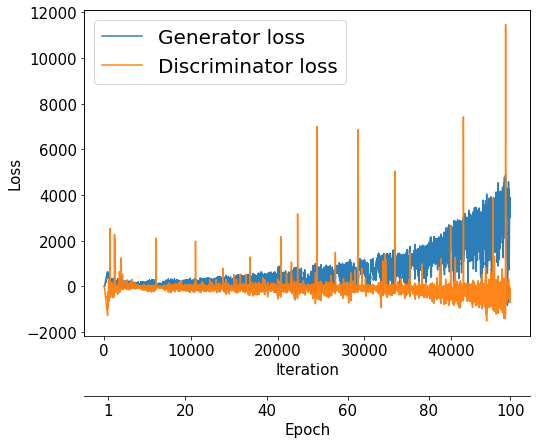

In [17]:
import itertools


fig = plt.figure(figsize=(8, 6))

# 손실 그래프
ax = fig.add_subplot(1, 1, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1] for item in itertools.chain(*all_losses)]
plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos   = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()

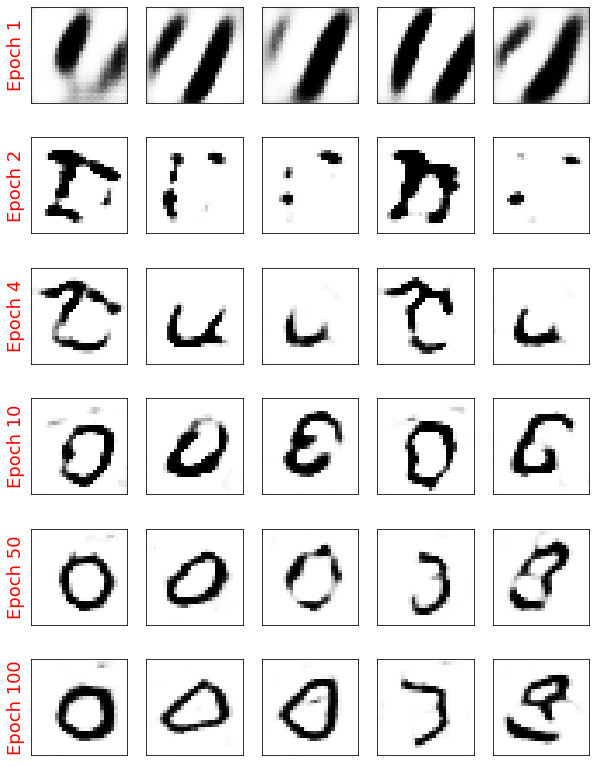

In [18]:
# 저장한 샘플 시각화
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'Epoch {}'.format(e),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
        
plt.show()

### 17.3.8 모드 붕괴

GAN은 적대적인 특징 때문에 훈련하기 어렵기로 악명이 높다. GAN을 훈련할 때 실패하는 흔한 이유 중 하나는 생성자가 작은 부분 공간에 갇혀 단순한 샘플만 생성하는 것을 합습할 때이다. 이를 **모드 붕괴**(mode collapse)라고 부른다.

In [19]:
# 모드 붕괴 예
Image(url='https://git.io/JLjcT', width=600)

생성자가 데이터의 전체 분포를 학습하지 못하고 한 부분 공간에 초점을 맞추는 데 그쳤음을 보여준다.

그레이디언트 폭주와 소멸 문제 외에도 GAN 훈련을 어렵게 만들 수 있는 또 다른 면이 있다(진짜 GAN 훈련은 예술에 가깝다).

* GAN 기법

1. 미니 배치 판별(mini-batch discrimination)

가짜나 진짜 샘플로만 이루어진 배치를 따로 판별자에게 주입한다. 미니 배치 판별에서는 판별자가 배치가 진짜인지 가짜인지 판단하기 위해 배치 안의 샘을 비교한다. 만약 모델이 모드 붕괴 문제를 겪고 있다면 진짜 샘플로만 구성도니 배치가 가짜 배치보다 다양성이 높을 것이다.

2. 특성 매칭(feature matching)

안정적인 GAN 훈련을 위한 기법으로 생성자의 목적 함수를 조금 수정한다. 판별자의 중간 표현(특성 맵)을 기반으로 원본 이미지와 합성 이미지 간의 차이를 최소화하는 추가적인 항을 더한다.

3. 경험 재생(experience replay)

훈련하는 동안에 GAN이 몇 개의 모드에 갇혀 이 사이를 왔다 갔다 할 수 있다. 이런 상황을 피하기 위해 저장된 예전 샘플 일부를 판별자에게 주입하여 생성자가 이전 모드를 다시 생성하지 않도록 방지할 수 있다. 또한, 랜덤 시드가 다른 여러 개의 GAN을 훈련하여 단일 모델이 아니라 모델의 조합이 전체 데이터 분포를 대부분 커버하게 만들 수 있다.